# Heart Attack Prediction

Create a normalized database (3NF).

In [2]:
import pandas as pd
import sqlite3

# Load the dataset
file_path = r'C:\UB ESDS\SEM 1\Python\heart_data.csv'  # Use a raw string (r'') for Windows file paths
heart_data = pd.read_csv(file_path)

# Connect to SQLite database (it will create the file if it doesn't exist)
conn = sqlite3.connect("heart_attack_prediction.db")
cursor = conn.cursor()

# Create Patients table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Patients (
    PatientID INTEGER PRIMARY KEY AUTOINCREMENT,
    Age INTEGER NOT NULL,
    Sex INTEGER NOT NULL
);
""")

# Create HealthMetrics table
cursor.execute("""
CREATE TABLE IF NOT EXISTS HealthMetrics (
    MetricID INTEGER PRIMARY KEY AUTOINCREMENT,
    PatientID INTEGER NOT NULL,
    Trestbps INTEGER NOT NULL,
    Chol INTEGER NOT NULL,
    Thalach INTEGER NOT NULL,
    Oldpeak REAL NOT NULL,
    FOREIGN KEY (PatientID) REFERENCES Patients(PatientID)
);
""")

# Create HeartAttackRisk table
cursor.execute("""
CREATE TABLE IF NOT EXISTS HeartAttackRisk (
    RiskID INTEGER PRIMARY KEY AUTOINCREMENT,
    PatientID INTEGER NOT NULL,
    Cp INTEGER NOT NULL,
    Target INTEGER NOT NULL,
    FOREIGN KEY (PatientID) REFERENCES Patients(PatientID)
);
""")

# Populate the Patients table
for index, row in heart_data.iterrows():
    cursor.execute("""
    INSERT INTO Patients (Age, Sex)
    VALUES (?, ?);
    """, (row['age'], row['sex']))

# Fetch PatientIDs to maintain relationships
cursor.execute("SELECT PatientID FROM Patients")
patient_ids = [row[0] for row in cursor.fetchall()]

# Populate the HealthMetrics table
for index, row in heart_data.iterrows():
    cursor.execute("""
    INSERT INTO HealthMetrics (PatientID, Trestbps, Chol, Thalach, Oldpeak)
    VALUES (?, ?, ?, ?, ?);
    """, (
        patient_ids[index],
        row['trestbps'],
        row['chol'],
        row['thalach'],
        row['oldpeak']
    ))

# Populate the HeartAttackRisk table
for index, row in heart_data.iterrows():
    cursor.execute("""
    INSERT INTO HeartAttackRisk (PatientID, Cp, Target)
    VALUES (?, ?, ?);
    """, (
        patient_ids[index],
        row['cp'],
        row['target']
    ))

# Commit and close the database connection
conn.commit()
conn.close()

print("Database and data insertion completed successfully!")


Database and data insertion completed successfully!


Write SQL join statement to fetch data from the database and into Pandas DataFrame.

In [5]:
import pandas as pd
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect("heart_attack_prediction.db")

# SQL query to join the tables and fetch data
query = """
SELECT 
    p.PatientID, 
    p.Age, 
    p.Sex, 
    hm.Trestbps, 
    hm.Chol, 
    hm.Thalach, 
    hm.Oldpeak, 
    har.Cp, 
    har.Target
FROM 
    Patients AS p
JOIN 
    HealthMetrics AS hm 
ON 
    p.PatientID = hm.PatientID
JOIN 
    HeartAttackRisk AS har 
ON 
    p.PatientID = har.PatientID;
"""

# Execute the query and load the data into a Pandas DataFrame
joined_data = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Display the DataFrame
print(joined_data.head())


   PatientID  Age  Sex  Trestbps  Chol  Thalach  Oldpeak  Cp  Target
0          1   63    1       145   233      150      2.3   3       1
1          2   37    1       130   250      187      3.5   2       1
2          3   41    0       130   204      172      1.4   1       1
3          4   56    1       120   236      178      0.8   1       1
4          5   57    0       120   354      163      0.6   0       1


Explore the data to determine if you need to stratify it by some attribute when doing train/test split. Perform the train/test split.

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None

Summary Statistics:
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54

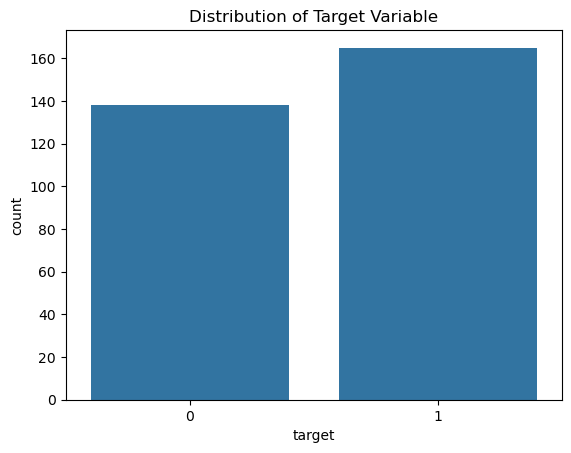

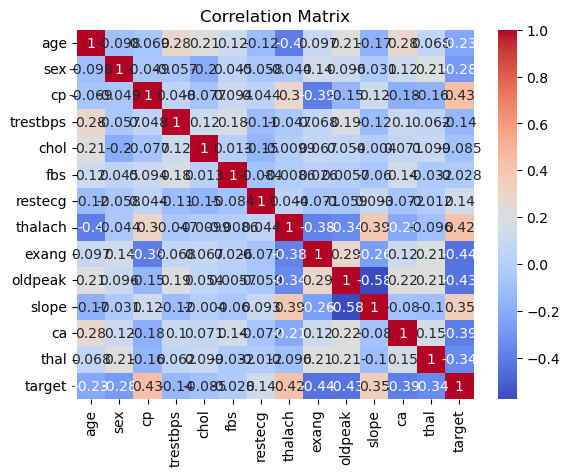

Train Target Distribution:
 target
1    0.545455
0    0.454545
Name: proportion, dtype: float64
Test Target Distribution:
 target
1    0.540984
0    0.459016
Name: proportion, dtype: float64
Train set size: (242, 13)
Test set size: (61, 13)


In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the dataset
joined_data = pd.read_csv("C:/UB ESDS/SEM 1/Python/heart_data.csv")

# Data exploration
print("Dataset Information:")
print(joined_data.info())

print("\nSummary Statistics:")
print(joined_data.describe())

print("\nChecking for missing values:")
print(joined_data.isnull().sum())

print("\nTarget Distribution:")
print(joined_data['target'].value_counts())

# Visualize the distribution of the target variable
sns.countplot(x='target', data=joined_data)
plt.title('Distribution of Target Variable')
plt.show()

# Visualizing correlations
correlation_matrix = joined_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Features and target
X = joined_data.drop(columns=['target'])  # Features
y = joined_data['target']  # Target

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Checking the distribution in the train and test sets
print("Train Target Distribution:\n", y_train.value_counts(normalize=True))
print("Test Target Distribution:\n", y_test.value_counts(normalize=True))

# Print train and test sizes
print(f"Train set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Explore the data using yprofile and correlation matrix. Make observations about features, distributions, capped values, and missing values. Create a list of data cleanup tasks.

In [27]:
pip install ydata-profiling

  Using cached dacite-1.8.1-py3-none-any.whl.metadata (15 kB)
Using cached dacite-1.8.1-py3-none-any.whl (14 kB)
  Attempting uninstall: dacite
    Found existing installation: dacite 1.6.0
    Uninstalling dacite-1.6.0:
      Successfully uninstalled dacite-1.6.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dagshub 0.4.0 requires dacite~=1.6.0, but you have dacite 1.8.1 which is incompatible.


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Missing Values Summary:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


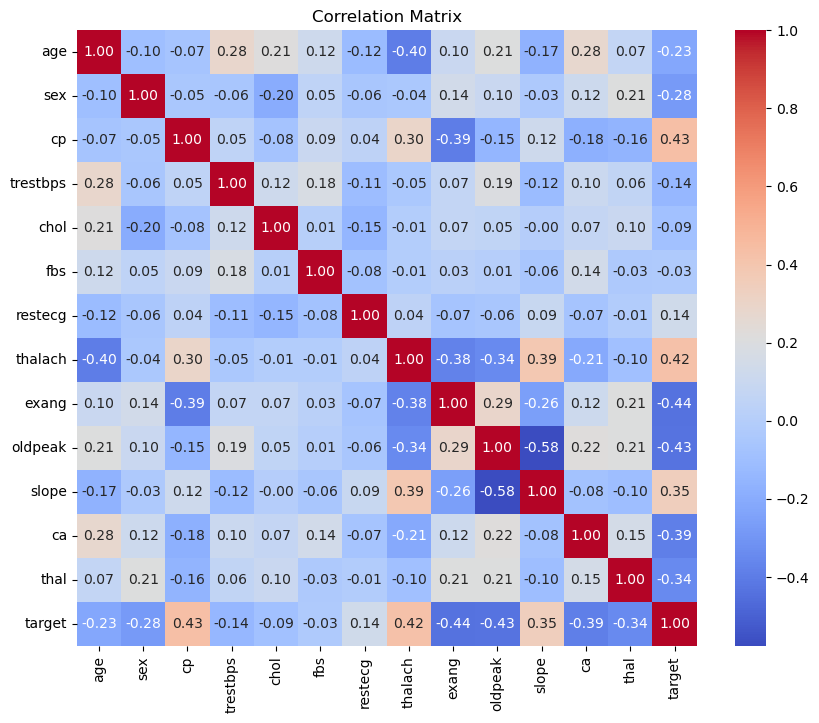


Data Cleanup Tasks:
- Investigate potential outliers in 'age'.
- Investigate potential outliers in 'trestbps'.
- Investigate potential outliers in 'chol'.
- Investigate potential outliers in 'restecg'.
- Investigate potential outliers in 'thalach'.
- Investigate potential outliers in 'oldpeak'.


In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport  # Requires 'pip install ydata-profiling'

# Load the dataset
joined_data = pd.read_csv("C:/UB ESDS/SEM 1/Python/heart_data.csv")

# Generate a profile report for the dataset
profile = ProfileReport(joined_data, title="Heart Data Profiling Report", explorative=True)
profile.to_file("heart_data_profile.html")  # Saves a detailed report as an HTML file

# Display a summary of missing values
print("Missing Values Summary:")
print(joined_data.isnull().sum())

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = joined_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Identify cleanup tasks
cleanup_tasks = []

# Check for missing values
if joined_data.isnull().sum().sum() > 0:
    cleanup_tasks.append("Handle missing values (imputation or removal).")

# Check for capped values (e.g., features with max values that seem unusual)
for col in joined_data.columns:
    if joined_data[col].dtype in ['int64', 'float64'] and joined_data[col].max() > joined_data[col].quantile(0.99):
        cleanup_tasks.append(f"Investigate potential outliers in '{col}'.")

# Add notes for any strongly correlated features (arbitrarily set at > 0.75)
correlated_features = [
    (col1, col2, corr_value)
    for col1 in correlation_matrix.columns
    for col2, corr_value in correlation_matrix[col1].items()  # Use `items()` instead of `iteritems()`
    if abs(corr_value) > 0.75 and col1 != col2
]
if correlated_features:
    for feat in correlated_features:
        cleanup_tasks.append(f"Consider dropping or transforming one of the highly correlated features: {feat[0]} and {feat[1]} (corr={feat[2]:.2f}).")

# List cleanup tasks
print("\nData Cleanup Tasks:")
for task in cleanup_tasks:
    print("-", task)


In [38]:
import pandas as pd

# Load the dataset
joined_data = pd.read_csv("C:/UB ESDS/SEM 1/Python/heart_data.csv")

# 1. Handle Missing Values
print("Missing Values Before Cleanup:")
print(joined_data.isnull().sum())

# Fill missing values (example: using median for numerical columns)
for col in joined_data.columns:
    if joined_data[col].isnull().sum() > 0:
        if joined_data[col].dtype in ['int64', 'float64']:
            joined_data[col].fillna(joined_data[col].median(), inplace=True)
        else:
            joined_data[col].fillna(joined_data[col].mode()[0], inplace=True)

print("Missing Values After Cleanup:")
print(joined_data.isnull().sum())

# 2. Investigate and Handle Outliers
# Using IQR to cap outliers
for col in joined_data.select_dtypes(include=['int64', 'float64']).columns:
    Q1 = joined_data[col].quantile(0.25)
    Q3 = joined_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    joined_data[col] = joined_data[col].clip(lower=lower_bound, upper=upper_bound)

# 3. Handle Highly Correlated Features
# Drop one of the highly correlated features (arbitrarily set threshold > 0.75)
correlation_matrix = joined_data.corr()
high_corr_pairs = [
    (col1, col2)
    for col1 in correlation_matrix.columns
    for col2 in correlation_matrix.columns
    if col1 != col2 and abs(correlation_matrix[col1][col2]) > 0.75
]

# Drop duplicate highly correlated features (keeping one)
features_to_drop = set()
for col1, col2 in high_corr_pairs:
    if col1 not in features_to_drop and col2 not in features_to_drop:
        features_to_drop.add(col2)

joined_data.drop(columns=list(features_to_drop), inplace=True)

# Final Dataset Summary
print("Final Dataset After Cleanup:")
print(joined_data.info())

# Save the cleaned dataset
joined_data.to_csv("cleaned_heart_data.csv", index=False)
print("Cleaned dataset saved as 'cleaned_heart_data.csv'")


Missing Values Before Cleanup:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
Missing Values After Cleanup:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
Final Dataset After Cleanup:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    float64
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    float

Experiment #1: Create a pipeline for preprocessing (StandardScaler, MinMaxScaler, LogTransformation, OneHotEncoding) and Logistic Regression. Log F1-score/(TP,TN,FN,FP)  in MLFlow on DagsHub. – Cross validation 3/10 folds. Results—mean/std of CV results and results on the whole training data – add in parameter hyper tuning

In [40]:
pip install mlflow dagshub scikit-learn numpy pandas


Note: you may need to restart the kernel to use updated packages.


In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn

# Load the cleaned dataset
data = pd.read_csv("cleaned_heart_data.csv")

# Split the data
X = data.drop(columns=['target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define preprocessing pipelines
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler()),  # Additional MinMaxScaler step
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Set up MLFlow for logging
import os
os.environ["MLFLOW_TRACKING_USERNAME"] = "monimithra"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "4dfd0dd546f9714f661d33b37d48dcaead2fd47f"

mlflow.set_tracking_uri("https://dagshub.com/monimithra/heart_attack_pred_final.mlflow")
mlflow.set_experiment("Heart Attack Prediction")

with mlflow.start_run():
    # Cross-validation (3/10 folds)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='f1')
    
    # Train on the entire training set
    pipeline.fit(X_train, y_train)
    
    # Evaluate on the test set
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Log parameters, metrics, and artifacts to MLFlow
    mlflow.log_param("Model", "Logistic Regression")
    mlflow.log_param("Preprocessing", "StandardScaler, MinMaxScaler, LogTransformation, OneHotEncoding")
    mlflow.log_metric("Mean CV F1-Score", np.mean(cv_scores))
    mlflow.log_metric("CV F1-Score Std", np.std(cv_scores))
    mlflow.log_metric("Test F1-Score", f1)
    mlflow.log_metric("True Negatives", tn)
    mlflow.log_metric("False Positives", fp)
    mlflow.log_metric("False Negatives", fn)
    mlflow.log_metric("True Positives", tp)

    # Log the model
    mlflow.sklearn.log_model(pipeline, "Logistic Regression Pipeline")

print("Experiment completed and logged to MLFlow.")


2024/12/19 22:45:38 INFO mlflow.tracking.fluent: Experiment with name 'Heart Attack Prediction' does not exist. Creating a new experiment.
2024/12/19 22:45:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run lyrical-stork-864 at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/0/runs/91eb6e4d99b4421ca55bd049a3d76cdb
🧪 View experiment at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/0
Experiment completed and logged to MLFlow.


Experiment #2: Create a pipeline for preprocessing and use LogisticRegression, RidgeClassifier, RandomForestClassifier, and XGBClassifier. Log results in MLFlow on DagsHub.

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn

# Load the cleaned dataset
data = pd.read_csv("cleaned_heart_data.csv")

# Split the data
X = data.drop(columns=['target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define preprocessing pipelines
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Ridge Classifier": RidgeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Set up MLFlow for logging
mlflow.set_tracking_uri("https://dagshub.com/monimithra/heart_attack_pred_final.mlflow")
mlflow.set_experiment("Heart Attack Prediction Experiment #2")

# Loop through classifiers
for name, model in classifiers.items():
    with mlflow.start_run(run_name=name):
        # Create pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('scaler', MinMaxScaler()),  # Additional scaling step
            ('classifier', model)
        ])
        
        # Cross-validation (10 folds)
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='f1')
        
        # Train on the entire training set
        pipeline.fit(X_train, y_train)
        
        # Evaluate on the test set
        y_pred = pipeline.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        # Log parameters, metrics, and model
        mlflow.log_param("Model", name)
        mlflow.log_metric("Mean CV F1-Score", np.mean(cv_scores))
        mlflow.log_metric("CV F1-Score Std", np.std(cv_scores))
        mlflow.log_metric("Test F1-Score", f1)
        mlflow.log_metric("True Negatives", tn)
        mlflow.log_metric("False Positives", fp)
        mlflow.log_metric("False Negatives", fn)
        mlflow.log_metric("True Positives", tp)
        mlflow.sklearn.log_model(pipeline, f"{name} Pipeline")
        
print("Experiment #2 completed and logged to MLFlow.")


2024/12/19 22:49:01 INFO mlflow.tracking.fluent: Experiment with name 'Heart Attack Prediction Experiment #2' does not exist. Creating a new experiment.
2024/12/19 22:49:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regression at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/1/runs/2477411d50e3434ba0e390278e17f601
🧪 View experiment at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/1


2024/12/19 22:49:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge Classifier at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/1/runs/b16d663fa942472e96c8df8dabc28167
🧪 View experiment at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/1


2024/12/19 22:49:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/1/runs/3d6063463891497280cbb429985df6a8
🧪 View experiment at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/1


C:\Anaconda_Navigator\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:49:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Anaconda_Navigator\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:49:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Anaconda_Navigator\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:49:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Anaconda_Navigator\Lib\site-packages\xgboost\core

🏃 View run XGBoost at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/1/runs/3e45e84f5b094f11864475394e8fbd83
🧪 View experiment at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/1
Experiment #2 completed and logged to MLFlow.


Experiment #3: Perform feature engineering and attribute combination. Log results in MLFlow.

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn

# Load the cleaned dataset
data = pd.read_csv("cleaned_heart_data.csv")

# Split the data
X = data.drop(columns=['target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature engineering
# Add new features: interaction terms and polynomial features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Model
model = LogisticRegression(max_iter=1000, random_state=42)

# Set up MLFlow for logging
mlflow.set_tracking_uri("https://dagshub.com/monimithra/heart_attack_pred_final.mlflow")
mlflow.set_experiment("Heart Attack Prediction Experiment #3")

with mlflow.start_run(run_name="Feature Engineering and Attribute Combination"):
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Cross-validation (10 folds)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='f1')
    
    # Train on the entire training set
    pipeline.fit(X_train, y_train)
    
    # Evaluate on the test set
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Log parameters, metrics, and model
    mlflow.log_param("Feature Engineering", "PolynomialFeatures (degree=2), Interaction terms")
    mlflow.log_param("Model", "Logistic Regression")
    mlflow.log_metric("Mean CV F1-Score", np.mean(cv_scores))
    mlflow.log_metric("CV F1-Score Std", np.std(cv_scores))
    mlflow.log_metric("Test F1-Score", f1)
    mlflow.log_metric("True Negatives", tn)
    mlflow.log_metric("False Positives", fp)
    mlflow.log_metric("False Negatives", fn)
    mlflow.log_metric("True Positives", tp)
    mlflow.sklearn.log_model(pipeline, "Feature Engineering Pipeline")

print("Experiment #3 completed and logged to MLFlow.")


2024/12/19 22:53:27 INFO mlflow.tracking.fluent: Experiment with name 'Heart Attack Prediction Experiment #3' does not exist. Creating a new experiment.
2024/12/19 22:53:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Feature Engineering and Attribute Combination at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/2/runs/ac3db1c6b01743d88a798be6758f278e
🧪 View experiment at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/2
Experiment #3 completed and logged to MLFlow.


Experiment #4: Perform feature selection using Correlation Threshold, Feature Importance, and Variance Threshold. Log results in MLFlow.

In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn

# Load the cleaned dataset
data = pd.read_csv("cleaned_heart_data.csv")

# Split the data
X = data.drop(columns=['target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 1. Feature Selection: Correlation Threshold
correlation_matrix = X_train.corr()
high_correlation_pairs = [
    (col1, col2) for col1 in correlation_matrix.columns for col2 in correlation_matrix.columns
    if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > 0.75
]

features_to_drop_corr = set([col2 for _, col2 in high_correlation_pairs])
X_train_corr_filtered = X_train.drop(columns=list(features_to_drop_corr), errors='ignore')
X_test_corr_filtered = X_test.drop(columns=list(features_to_drop_corr), errors='ignore')

# 2. Feature Selection: Variance Threshold
var_thresh_selector = VarianceThreshold(threshold=0.01)
X_train_var_filtered = var_thresh_selector.fit_transform(X_train_corr_filtered)
X_test_var_filtered = var_thresh_selector.transform(X_test_corr_filtered)

# 3. Feature Selection: Feature Importance (Random Forest)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_var_filtered, y_train)
feature_importances = rf.feature_importances_
important_features = [
    feature for feature, importance in zip(X_train_corr_filtered.columns, feature_importances)
    if importance > 0.01
]

X_train_final = pd.DataFrame(X_train_var_filtered, columns=important_features)
X_test_final = pd.DataFrame(X_test_var_filtered, columns=important_features)

# Set up MLFlow for logging
mlflow.set_tracking_uri("https://dagshub.com/monimithra/heart_attack_pred_final.mlflow")
mlflow.set_experiment("Heart Attack Prediction Experiment #4")

with mlflow.start_run(run_name="Feature Selection"):
    # Train model with selected features
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_final, y_train)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_final, y_train, cv=10, scoring='f1')
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_final)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Log results in MLFlow
    mlflow.log_param("Feature Selection Methods", "Correlation Threshold, Variance Threshold, Feature Importance")
    mlflow.log_param("Selected Features", important_features)
    mlflow.log_metric("Mean CV F1-Score", np.mean(cv_scores))
    mlflow.log_metric("CV F1-Score Std", np.std(cv_scores))
    mlflow.log_metric("Test F1-Score", f1)
    mlflow.log_metric("True Negatives", tn)
    mlflow.log_metric("False Positives", fp)
    mlflow.log_metric("False Negatives", fn)
    mlflow.log_metric("True Positives", tp)
    mlflow.sklearn.log_model(model, "Feature Selection Model")

print("Experiment #4 completed and logged to MLFlow.")


2024/12/19 22:56:12 INFO mlflow.tracking.fluent: Experiment with name 'Heart Attack Prediction Experiment #4' does not exist. Creating a new experiment.
2024/12/19 22:56:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Feature Selection at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/3/runs/7cbc614ee68848158c318e9d405faa22
🧪 View experiment at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/3
Experiment #4 completed and logged to MLFlow.


Experiment #5: Use PCA for dimensionality reduction on all the features. Create a scree plot to show which components will be selected for classification. Log results in MLFlow.

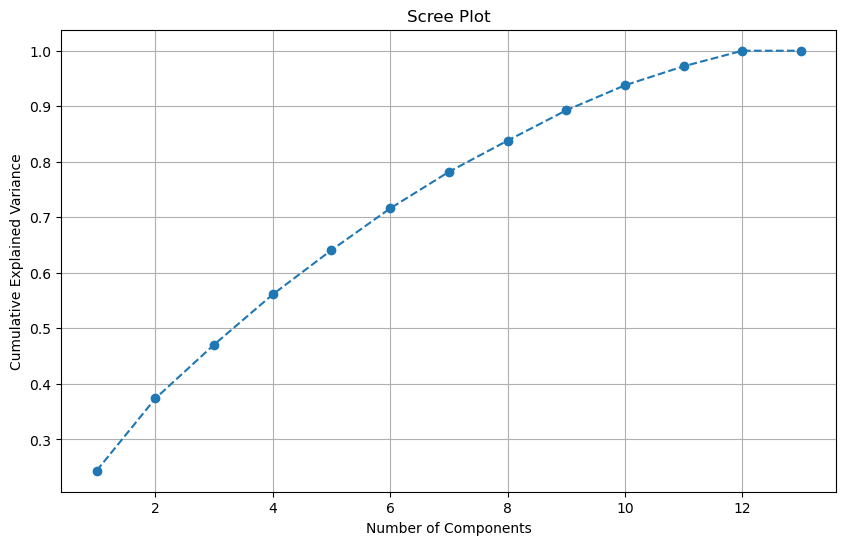

2024/12/19 22:58:19 INFO mlflow.tracking.fluent: Experiment with name 'Heart Attack Prediction Experiment #5' does not exist. Creating a new experiment.
2024/12/19 22:58:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run PCA Dimensionality Reduction at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/4/runs/57bb89448f684a5b88b6826a19888f7f
🧪 View experiment at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/4
PCA Experiment completed with 11 components. Results logged to MLFlow.


In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn

# Load the cleaned dataset
data = pd.read_csv("cleaned_heart_data.csv")

# Split the data
X = data.drop(columns=['target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the data before applying PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Scree plot to show explained variance ratio
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid()
plt.show()

# Choose the number of components that explain 95% of the variance
n_components = np.argmax(np.cumsum(explained_variance) >= 0.95) + 1
pca = PCA(n_components=n_components)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

# Set up MLFlow for logging
mlflow.set_tracking_uri("https://dagshub.com/monimithra/heart_attack_pred_final.mlflow")
mlflow.set_experiment("Heart Attack Prediction Experiment #5")

with mlflow.start_run(run_name="PCA Dimensionality Reduction"):
    # Train Logistic Regression on PCA-transformed data
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_reduced, y_train)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_reduced, y_train, cv=10, scoring='f1')
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_reduced)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Log results in MLFlow
    mlflow.log_param("PCA Components", n_components)
    mlflow.log_metric("Mean CV F1-Score", np.mean(cv_scores))
    mlflow.log_metric("CV F1-Score Std", np.std(cv_scores))
    mlflow.log_metric("Test F1-Score", f1)
    mlflow.log_metric("True Negatives", tn)
    mlflow.log_metric("False Positives", fp)
    mlflow.log_metric("False Negatives", fn)
    mlflow.log_metric("True Positives", tp)
    mlflow.sklearn.log_model(model, "PCA Model")

print(f"PCA Experiment completed with {n_components} components. Results logged to MLFlow.")


Experiment #6: Design and execute a custom experiment. Log results in MLFlow.

In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE  # Install with `pip install imbalanced-learn`
import mlflow
import mlflow.sklearn

# Load the cleaned dataset
data = pd.read_csv("cleaned_heart_data.csv")

# Split the data
X = data.drop(columns=['target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Set up MLFlow for logging
mlflow.set_tracking_uri("https://dagshub.com/monimithra/heart_attack_pred_final.mlflow")
mlflow.set_experiment("Heart Attack Prediction Experiment #6")

with mlflow.start_run(run_name="Custom Experiment with SMOTE and Gradient Boosting"):
    # Train Gradient Boosting Classifier
    model = GradientBoostingClassifier(random_state=42)
    model.fit(X_train_balanced, y_train_balanced)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=10, scoring='f1')
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Log results in MLFlow
    mlflow.log_param("Oversampling Method", "SMOTE")
    mlflow.log_param("Model", "Gradient Boosting Classifier")
    mlflow.log_metric("Mean CV F1-Score", np.mean(cv_scores))
    mlflow.log_metric("CV F1-Score Std", np.std(cv_scores))
    mlflow.log_metric("Test F1-Score", f1)
    mlflow.log_metric("True Negatives", tn)
    mlflow.log_metric("False Positives", fp)
    mlflow.log_metric("False Negatives", fn)
    mlflow.log_metric("True Positives", tp)
    mlflow.sklearn.log_model(model, "SMOTE and Gradient Boosting Model")

print("Custom Experiment #6 completed and logged to MLFlow.")


2024/12/19 23:17:46 INFO mlflow.tracking.fluent: Experiment with name 'Heart Attack Prediction Experiment #6' does not exist. Creating a new experiment.
2024/12/19 23:18:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Custom Experiment with SMOTE and Gradient Boosting at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/5/runs/5e9b42555e01422cb7ef92d816c03286
🧪 View experiment at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/5
Custom Experiment #6 completed and logged to MLFlow.


Experiment #7: Design and execute another custom experiment. Log results in MLFlow.

In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import mlflow
import mlflow.sklearn

# Load the cleaned dataset
data = pd.read_csv("cleaned_heart_data.csv")

# Split the data
X = data.drop(columns=['target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set up MLFlow for logging
mlflow.set_tracking_uri("https://dagshub.com/monimithra/heart_attack_pred_final.mlflow")
mlflow.set_experiment("Heart Attack Prediction Experiment #7")

with mlflow.start_run(run_name="Custom Experiment with k-NN and Hyperparameter Tuning"):
    # Set up k-NN with GridSearchCV
    param_grid = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='f1', n_jobs=-1)
    
    # Train the model with hyperparameter tuning
    grid_search.fit(X_train_scaled, y_train)
    
    # Best parameters and best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    # Evaluate the best model on the test set
    y_pred = best_model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Log results in MLFlow
    mlflow.log_param("Hyperparameters", best_params)
    mlflow.log_param("Model", "k-Nearest Neighbors (k-NN)")
    mlflow.log_metric("Best CV F1-Score", grid_search.best_score_)
    mlflow.log_metric("Test F1-Score", f1)
    mlflow.log_metric("True Negatives", tn)
    mlflow.log_metric("False Positives", fp)
    mlflow.log_metric("False Negatives", fn)
    mlflow.log_metric("True Positives", tp)
    mlflow.sklearn.log_model(best_model, "k-NN Best Model")

print("Custom Experiment #7 completed and logged to MLFlow.")


2024/12/19 23:20:59 INFO mlflow.tracking.fluent: Experiment with name 'Heart Attack Prediction Experiment #7' does not exist. Creating a new experiment.
2024/12/19 23:21:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Custom Experiment with k-NN and Hyperparameter Tuning at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/6/runs/2a839d5d9ccb4177855abac81fce1fc0
🧪 View experiment at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/6
Custom Experiment #7 completed and logged to MLFlow.


Create meaningful F1-score plots to compare experiments and determine the best model.

2024/12/19 23:25:14 INFO mlflow.tracking.fluent: Experiment with name 'Heart Attack Prediction Combined Experiments' does not exist. Creating a new experiment.
2024/12/19 23:25:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regression at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/7/runs/04889f1070a740939ea5275efee98cf2
🧪 View experiment at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/7


2024/12/19 23:25:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/7/runs/d9d1ba688425420b99e74cce8779ba27
🧪 View experiment at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/7


2024/12/19 23:26:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Feature Engineering with SMOTE at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/7/runs/87cc372d4a7746d4a579af4249edd474
🧪 View experiment at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/7


2024/12/19 23:26:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run PCA at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/7/runs/7522045f58fa4fae801da2a01614fdef
🧪 View experiment at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/7


2024/12/19 23:26:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run k-NN with Hyperparameter Tuning at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/7/runs/7fedc035044d471f82f8c8dc1966147b
🧪 View experiment at: https://dagshub.com/monimithra/heart_attack_pred_final.mlflow/#/experiments/7


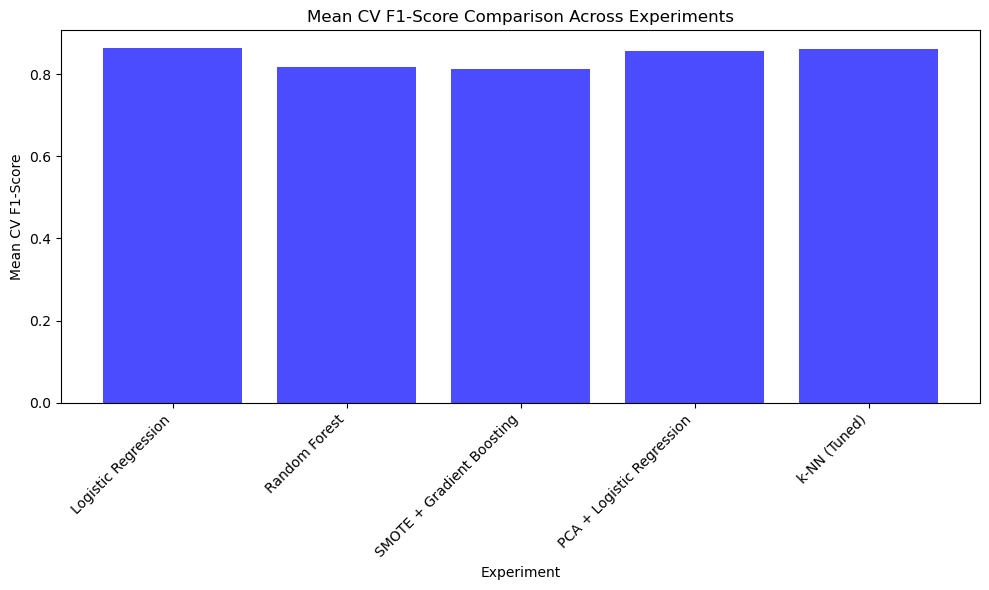

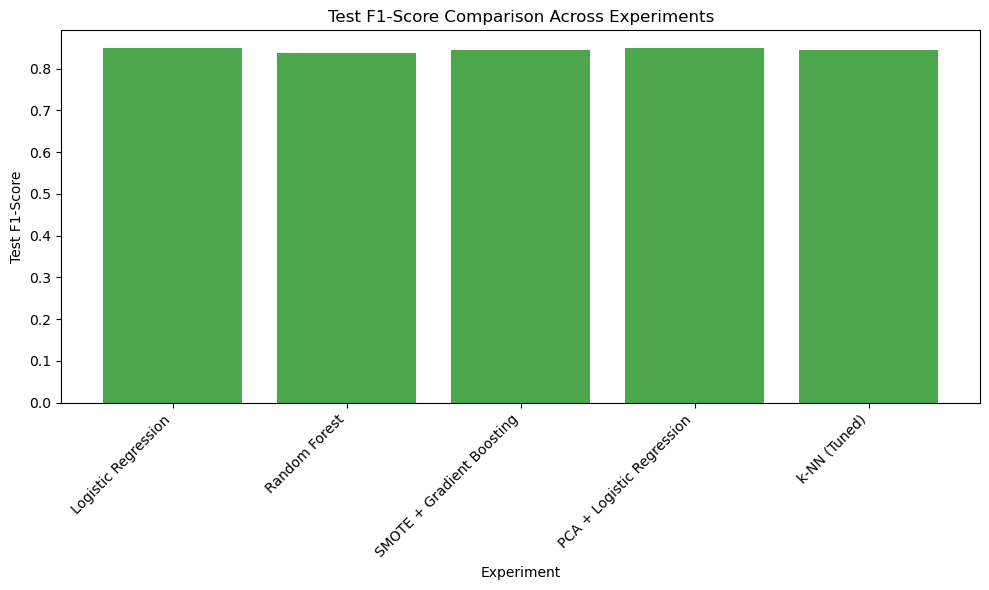

In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE  # Install with `pip install imbalanced-learn`
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt

# Load the cleaned dataset
data = pd.read_csv("cleaned_heart_data.csv")

# Split the data
X = data.drop(columns=['target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set up MLFlow for logging
mlflow.set_tracking_uri("https://dagshub.com/monimithra/heart_attack_pred_final.mlflow")
mlflow.set_experiment("Heart Attack Prediction Combined Experiments")

# Store results for comparison
results = []

# Experiment 1: Logistic Regression
with mlflow.start_run(run_name="Logistic Regression"):
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='f1')
    results.append({"Experiment": "Logistic Regression", "Mean CV F1-Score": np.mean(cv_scores), "Test F1-Score": f1})
    mlflow.log_metric("Mean CV F1-Score", np.mean(cv_scores))
    mlflow.log_metric("Test F1-Score", f1)
    mlflow.sklearn.log_model(model, "Logistic Regression")

# Experiment 2: Random Forest
with mlflow.start_run(run_name="Random Forest"):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='f1')
    results.append({"Experiment": "Random Forest", "Mean CV F1-Score": np.mean(cv_scores), "Test F1-Score": f1})
    mlflow.log_metric("Mean CV F1-Score", np.mean(cv_scores))
    mlflow.log_metric("Test F1-Score", f1)
    mlflow.sklearn.log_model(model, "Random Forest")

# Experiment 3: Feature Engineering (Gradient Boosting + SMOTE)
with mlflow.start_run(run_name="Feature Engineering with SMOTE"):
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
    model = GradientBoostingClassifier(random_state=42)
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=10, scoring='f1')
    results.append({"Experiment": "SMOTE + Gradient Boosting", "Mean CV F1-Score": np.mean(cv_scores), "Test F1-Score": f1})
    mlflow.log_metric("Mean CV F1-Score", np.mean(cv_scores))
    mlflow.log_metric("Test F1-Score", f1)
    mlflow.sklearn.log_model(model, "SMOTE + Gradient Boosting")

# Experiment 4: PCA + Logistic Regression
with mlflow.start_run(run_name="PCA"):
    pca = PCA(n_components=0.95, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    f1 = f1_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train_pca, y_train, cv=10, scoring='f1')
    results.append({"Experiment": "PCA + Logistic Regression", "Mean CV F1-Score": np.mean(cv_scores), "Test F1-Score": f1})
    mlflow.log_metric("Mean CV F1-Score", np.mean(cv_scores))
    mlflow.log_metric("Test F1-Score", f1)
    mlflow.sklearn.log_model(model, "PCA + Logistic Regression")

# Experiment 5: k-NN + Hyperparameter Tuning
with mlflow.start_run(run_name="k-NN with Hyperparameter Tuning"):
    param_grid = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)
    cv_scores = grid_search.best_score_
    results.append({"Experiment": "k-NN (Tuned)", "Mean CV F1-Score": cv_scores, "Test F1-Score": f1})
    mlflow.log_metric("Mean CV F1-Score", cv_scores)
    mlflow.log_metric("Test F1-Score", f1)
    mlflow.sklearn.log_model(best_model, "k-NN Best Model")

# Plot F1-score comparison
results_df = pd.DataFrame(results)

# Plot Mean CV F1-Score
plt.figure(figsize=(10, 6))
plt.bar(results_df["Experiment"], results_df["Mean CV F1-Score"], color="blue", alpha=0.7)
plt.title("Mean CV F1-Score Comparison Across Experiments")
plt.xlabel("Experiment")
plt.ylabel("Mean CV F1-Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot Test F1-Score
plt.figure(figsize=(10, 6))
plt.bar(results_df["Experiment"], results_df["Test F1-Score"], color="green", alpha=0.7)
plt.title("Test F1-Score Comparison Across Experiments")
plt.xlabel("Experiment")
plt.ylabel("Test F1-Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Save the final model using joblib.
Create a FastAPI application to serve the model.
Containerize the FastAPI application using Docker and push to Docker Hub.
Deploy the containerized API to a cloud platform.


In [72]:
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# Load the cleaned dataset
data = pd.read_csv("cleaned_heart_data.csv")

# Split the data
X = data.drop(columns=['target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train Logistic Regression model
final_model = LogisticRegression(max_iter=1000, random_state=42)
final_model.fit(X_train_pca, y_train)

# Save the PCA, scaler, and model using joblib
joblib.dump(scaler, "scaler.joblib")
joblib.dump(pca, "pca.joblib")
joblib.dump(final_model, "final_model_pca_lr.joblib")

print("Final PCA + Logistic Regression model saved as 'final_model_pca_lr.joblib'.")
print("Scaler and PCA components saved as 'scaler.joblib' and 'pca.joblib'.")


Final PCA + Logistic Regression model saved as 'final_model_pca_lr.joblib'.
Scaler and PCA components saved as 'scaler.joblib' and 'pca.joblib'.
